In [1]:
train_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\train'
test_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\test'
val_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\val'
# train_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\结项\cut622-1\train'
# test_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\结项\cut622-1\test'
# val_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\结项\cut622-1\val'

In [2]:
import os
import keras
import numpy as np
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, save_model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Activation
from sklearn.metrics import accuracy_score, average_precision_score, precision_score, f1_score, recall_score


In [3]:
dim = (188,218)           
zoom = [.91, 1.10]          
bright_range = [.8,1.2]       

In [4]:
batch_size = 32
inputShape = (dim[0], dim[1], 3)
train_Generator = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0,
                               brightness_range=bright_range, zoom_range=zoom, horizontal_flip=True)

train_data = train_Generator.flow_from_directory(train_root, target_size=dim, batch_size=batch_size)


Generator = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0)
Generator_TTA = ImageDataGenerator(rescale=1/255, fill_mode='constant', cval=0, horizontal_flip=True)

train_data_original=Generator.flow_from_directory(train_root, target_size=dim, batch_size=batch_size)

val_data = Generator.flow_from_directory(val_root, target_size=dim, batch_size=batch_size)

test_data = Generator.flow_from_directory(test_root, target_size=dim, batch_size=batch_size, shuffle=False)
test_data_TTA = Generator_TTA.flow_from_directory(test_root, target_size=dim, batch_size=batch_size, shuffle=False)
num_classes = len([i for i in os.listdir(train_root)])
print(num_classes)

Found 6852 images belonging to 4 classes.
Found 6852 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
Found 2289 images belonging to 4 classes.
Found 2289 images belonging to 4 classes.
4


In [5]:
import random

args = 12
np.random.seed(args)

random.seed(args)              ##

# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 
adam=tf.keras.optimizers.Adam(learning_rate=0.001)

In [6]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1, mode='max', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, mode='max', cooldown=1, min_lr=1e-8)
callback_list = [earlyStopping, reduce]


In [7]:
def get_result_2(model_history,vg_model,test_data,test_data_TTA):
    #     train_scores = vg_model.evaluate(train_data, train_labels)
#     val_scores = vg_model.evaluate(val_data,val_labels)
    test_scores = vg_model.evaluate(test_data)

#     print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
#     print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
    print('Test Accuracy: %.2f%%'%(test_scores[1]*100))
    
    fig, ax = plt.subplots(1, 2, figsize = (30, 5))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])
        
    pred = vg_model.predict(test_data)
    pred=np.argmax(pred,axis=1)
    
    # TTA_WAY

    cm = confusion_matrix(y_true= test_data.classes,y_pred=pred,labels=[0,1,2,3])

    # sns.heatmap(cm,annot = True)
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = sn.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Non', 'VeryMild'],
            yticklabels=['Mild', 'Moderate', 'Non', 'VeryMild'])
    plt.title('Alzheimer\'s Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    # plt.subplots(figsize=(9, 6))
    plt.show(ax)
    print('------Weighted------')
    print('Weighted precision', precision_score(test_data.classes, pred, average='weighted'))
    print('Weighted recall', recall_score(test_data.classes, pred, average='weighted'))
    print('Weighted f1-score', f1_score(test_data.classes, pred, average='weighted'))
    print('------Macro------')
    print('Macro precision', precision_score(test_data.classes, pred, average='macro'))
    print('Macro recall', recall_score(test_data.classes, pred, average='macro'))
    print('Macro f1-score', f1_score(test_data.classes, pred, average='macro'))
    print('------Micro------')
    print('Micro precision', precision_score(test_data.classes, pred, average='micro'))
    print('Micro recall', recall_score(test_data.classes, pred, average='micro'))
    print('Micro f1-score', f1_score(test_data.classes, pred, average='micro'))
    
    tta_steps = 10

    predictions = []
    
    for i in range(tta_steps):
    #     preds = model.predict_generator(test_datagen.flow(test_data, batch_size=batch_size, shuffle=False), steps = len(test_data)/batch_size)
        preds = model.predict(test_data_TTA,verbose=1)
        predictions.append(preds)

    final_pred = np.mean(predictions, axis=0)
    pred = np.argmax(final_pred, axis=-1)
    true = test_data.classes
    
    print('------TTA_SCORE------')
    print(f'Accuracy with TTA: {np.mean(np.equal(pred,true))}')
    


In [8]:
vg_model = tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                weights='imagenet', 
                                                input_shape=(dim[0],dim[1],3),
                                                   pooling="max", 
                                                   classes=4)
#     vg_model.trainable = False
vg_model.get_layer('conv2_block1_2_conv').trainable = False
vg_model.get_layer('conv2_block1_3_conv').trainable = False
#     vg_model.get_layer('conv2_block1_0_conv').trainable = True
#     vg_model.get_layer('conv2_block1_3_conv').trainable = True
#     vg_model.get_layer('conv2_block2_1_conv').trainable = False
vg_model.get_layer('conv2_block2_3_conv').trainable = False

vg_model.get_layer('conv3_block3_2_conv').trainable = False
vg_model.get_layer('conv3_block3_3_conv').trainable = False

#     vg_model.get_layer('conv3_block4_1_conv').trainable = False
vg_model.get_layer('conv3_block4_2_conv').trainable = False

vg_model.get_layer('conv4_block1_2_conv').trainable = False
vg_model.get_layer('conv4_block1_3_conv').trainable = False

vg_model.get_layer('conv4_block2_2_conv').trainable = False
vg_model.get_layer('conv4_block2_3_conv').trainable = False

vg_model.get_layer('conv4_block3_2_conv').trainable = False
vg_model.get_layer('conv4_block3_3_conv').trainable = False

vg_model.get_layer('conv4_block4_2_conv').trainable = False
vg_model.get_layer('conv4_block4_3_conv').trainable = False

vg_model.get_layer('conv4_block5_2_conv').trainable = False
vg_model.get_layer('conv4_block5_3_conv').trainable = False

vg_model.get_layer('conv5_block3_2_conv').trainable = False
vg_model.get_layer('conv5_block3_3_conv').trainable = False
#     vg_model.get_layer('conv4_block6_2_conv').trainable = False
#     vg_model.get_layer('conv4_block6_3_conv').trainable = False


vg_model.summary()
    



model=Sequential()
model.add(vg_model)
# model.add(Flatten())

model.add(Dense(1024,
                kernel_regularizer=regularizers.l2(0.0001),
                kernel_initializer='he_uniform')
          )
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25) )
# model.add(Dropout(0.3) )

model.add(Dense(4,activation='softmax') )
model.summary()




Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 188, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 194, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 94, 109, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 94, 109, 64)  256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 47, 55, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 47, 55, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 47, 55, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 47, 55, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 24, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 24, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 24, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 24, 28, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 12, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 12, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 12, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 12, 14, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 12, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 12, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 12, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 12, 14, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 6, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 6, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 6, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 6, 7, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [9]:
model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
model_history = model.fit(train_data,validation_data=val_data,callbacks= callback_list,
                             epochs=100, shuffle=True)

Epoch 1/100
215/215 [==============================] - 101s 409ms/step - loss: 1.2312 - accuracy: 0.5474 - val_loss: 1.7222 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 2/100
215/215 [==============================] - 91s 421ms/step - loss: 1.0328 - accuracy: 0.6311 - val_loss: 1.3226 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 3/100
215/215 [==============================] - 95s 439ms/step - loss: 1.0322 - accuracy: 0.6332 - val_loss: 1.2798 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 4/100
215/215 [==============================] - 94s 435ms/step - loss: 0.9488 - accuracy: 0.6518 - val_loss: 1.2057 - val_accuracy: 0.4336 - lr: 0.0010
Epoch 5/100
215/215 [==============================] - 97s 450ms/step - loss: 0.7809 - accuracy: 0.7185 - val_loss: 0.9858 - val_accuracy: 0.5896 - lr: 0.0010
Epoch 6/100
215/215 [==============================] - 97s 448ms/step - loss: 0.6670 - accuracy: 0.7593 - val_loss: 0.6707 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 7/100
215/215 [========================

Epoch 50/100
215/215 [==============================] - 110s 510ms/step - loss: 0.0242 - accuracy: 0.9985 - val_loss: 0.0601 - val_accuracy: 0.9873 - lr: 1.0000e-05
Epoch 51/100
215/215 [==============================] - 110s 509ms/step - loss: 0.0220 - accuracy: 0.9987 - val_loss: 0.0607 - val_accuracy: 0.9882 - lr: 1.0000e-05
Epoch 52/100
215/215 [==============================] - 110s 509ms/step - loss: 0.0223 - accuracy: 0.9987 - val_loss: 0.0589 - val_accuracy: 0.9886 - lr: 1.0000e-05
Epoch 53/100
215/215 [==============================] - 110s 511ms/step - loss: 0.0215 - accuracy: 0.9990 - val_loss: 0.0557 - val_accuracy: 0.9895 - lr: 1.0000e-05
Epoch 54/100
215/215 [==============================] - 108s 502ms/step - loss: 0.0233 - accuracy: 0.9978 - val_loss: 0.0542 - val_accuracy: 0.9895 - lr: 1.0000e-05
Epoch 55/100
215/215 [==============================] - 109s 507ms/step - loss: 0.0229 - accuracy: 0.9985 - val_loss: 0.0536 - val_accuracy: 0.9886 - lr: 1.0000e-05
Epoch 56/1

In [10]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc
 
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))
reset_keras()

21


72/72 [==============================] - 10s 134ms/step - loss: 0.0597 - accuracy: 0.9895
Test Accuracy: 98.95%
72/72 [==============================] - 10s 118ms/step


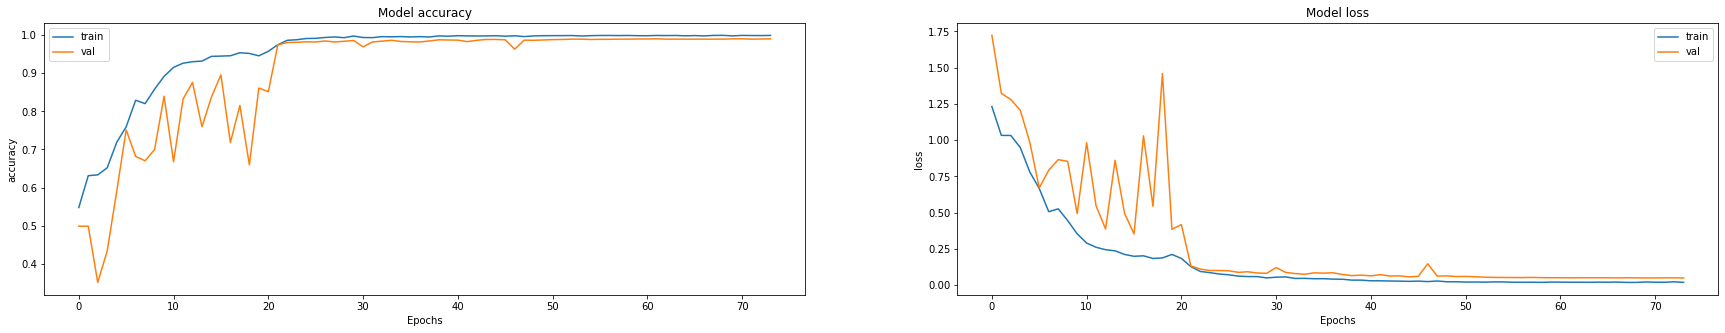

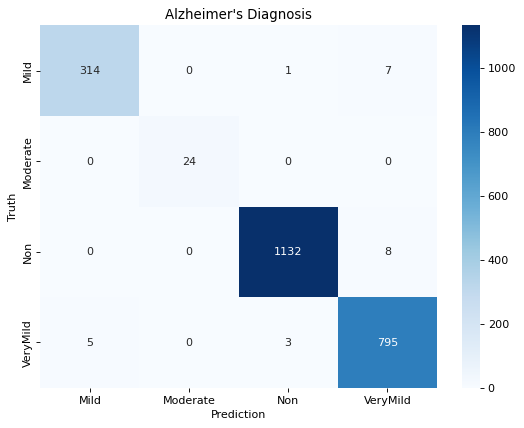

------Weighted------
Weighted precision 0.9895450079419019
Weighted recall 0.9895150720838795
Weighted f1-score 0.9895189781447206
------Macro------
Macro precision 0.9905715933824238
Macro recall 0.9895437738859575
Macro f1-score 0.9900469091458384
------Micro------
Micro precision 0.9895150720838795
Micro recall 0.9895150720838795
Micro f1-score 0.9895150720838795
72/72 [==============================] - 8s 116ms/step
------TTA_SCORE------
Accuracy with TTA: 0.9912625600698995


In [11]:
get_result_2(model_history,model,test_data,test_data_TTA)


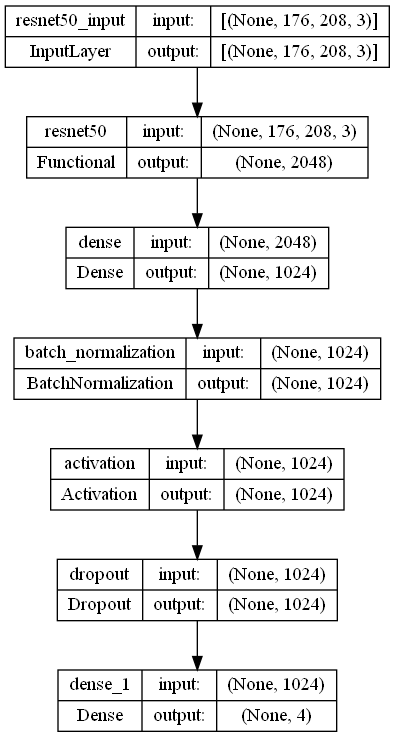

In [12]:
keras.utils.plot_model(model,  to_file="9-0,5-0,5_resnet.png", show_shapes=True)